[Open in Google Colab](https://colab.research.google.com/drive/1mIvGMGz09Ku4V1fMFbYjHymO42W3yi9S#scrollTo=view-in-github)

## Project #1 - AI Technical Principles & Basics  
*Johnathan Long*  
*Predictive Model*
___


**Introduction**  

Artificial Intelligence has various use cases, such as prediction, detection, and generation. Its primary role is to identify correlations between variables. With a deeper understanding of these correlations, inferences can be made.

In this project, I want to compare two machine learning algorithms intended to perform predictive analysis. The focus is on understanding AI's internal mechanics and building a program to print metrics for further developments. Here I detail basic machine learning methods, intended to devliver an understanding of How AI works _"from the inside"_ digestable for clientele, students, or researchers. Please note, that although basic methodology and approach may follow a general pattern, each machine learning model requires unique structure and architecture based upon the problem at hand.

We begin by introducing a "[Heat Disease Prediction](https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction)" dataset from Kaggle. The patient health data consist of features that can be used to predict if patients have high risk for heart disease.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
file_path = '/content/Heart_Disease_Prediction.csv'
df = pd.read_csv(file_path)

print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

**Pre-processing**  

Preprocessing is a common step within most all data specific approaches ensuring the data is clean, structured and suitable for use. We visualize the first few rows of the dataset, datatype and features. There are 270 entries, 14 features, one of which is _"object"_ type, or _"categorical"_. There are no missing values, indicating that we have a clean dataset.

Here the Heart Disease column is the _"target variable"_, or the variable that we are predicting. This column is seperated into _"Absence"_ of heart disease (Negative Class) and _"Presence"_ of heart disease(Positive Class). Because there exist only two possibilities, we can label this a _Binary Classification_ problem. (predictions will either be "yes" or "no")

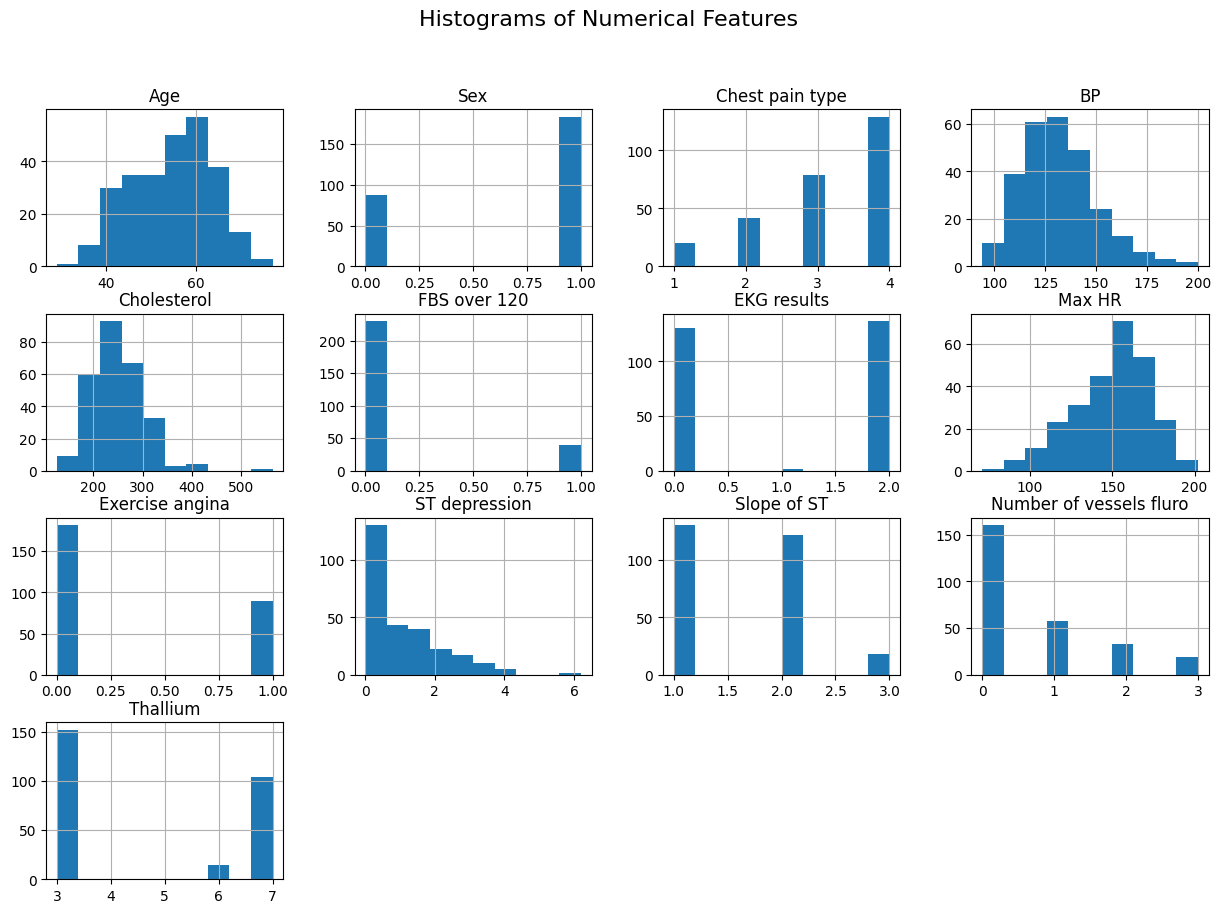

In [4]:
# this is a histograms for all numerical columns
df.hist(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

Plotting histograms is common practice and allows us to grasp insights about the data we will be analyzing. Inferences can be made such as - Most patients have fasting blood sugar levels not over 120 mg/dL.  

Let's look at the "Sex" feature, where we may see an uneven distribution.


In [5]:
# I need to check the distribution of men versus women
gender_distribution = df['Sex'].value_counts()
print("Gender Distribution (0 = Female, 1 = Male):")
print(gender_distribution)


Gender Distribution (0 = Female, 1 = Male):
Sex
1    183
0     87
Name: count, dtype: int64


We see here that the number of Males outweigh the number of Females by almost 3 times as much. This is specific to the dataset. Whenever there are uneven distributions within the data, we can apply over/under sampling techniques to reduce the risk of bias. However this should be performed under careful consideration as it could result in misleading outputs.  

Next we will see the number of heart disease vs no heart disease.

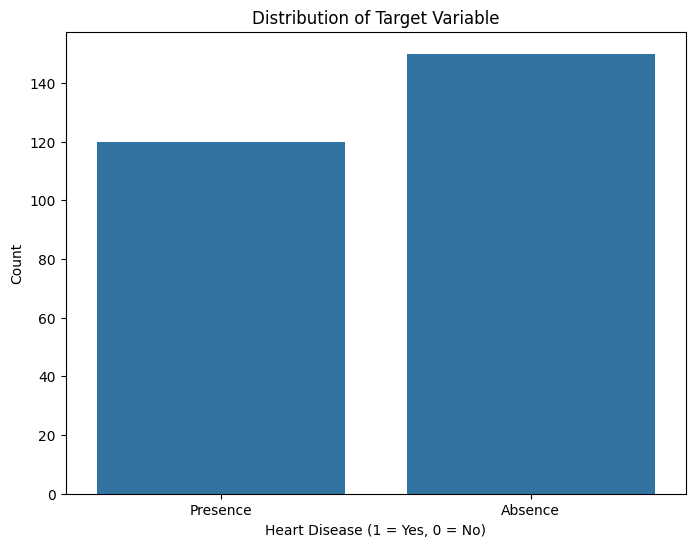

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Heart Disease', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Heart Disease (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()



Box plots are great for visualizing any outliers if present. Outliers can arrise when there are mismeasurement or innacuracies within data collection, however if the nature of the outliers lie within the true instance of the data it may be prefered to retain them. This does not hold true for binary (yes/no) features.  

The specific outliers in Cholesterol, BP, and ST Depression will be capped at the 95th percentile to mitigate their impact and improve stability in the model.

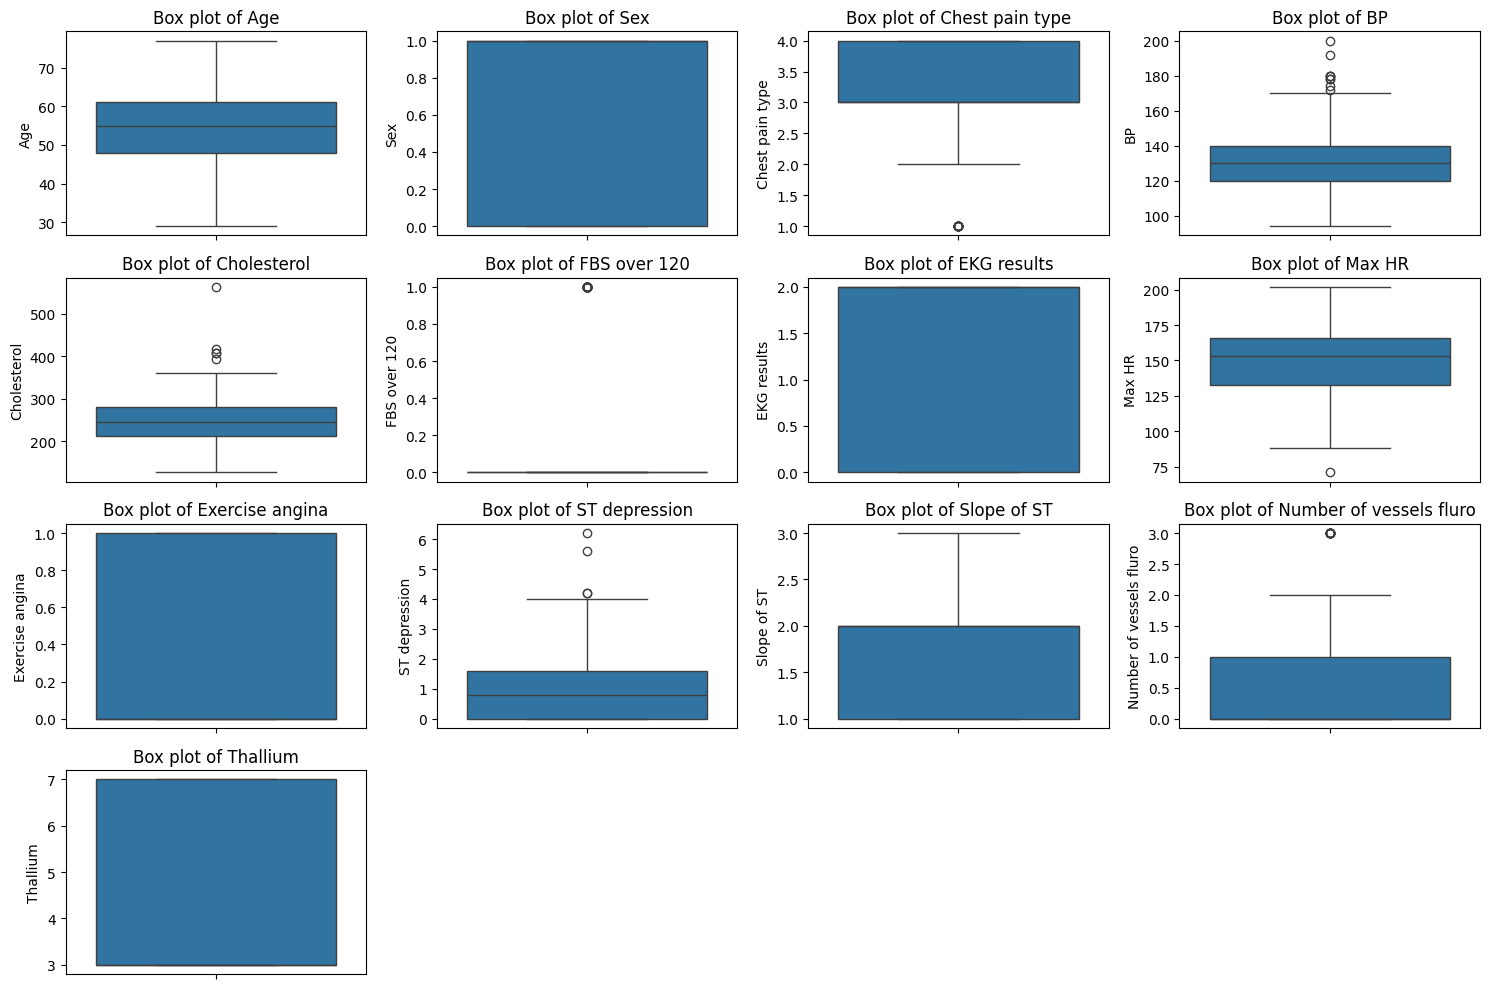

In [7]:
# We are going to perform correlation analysis to identify potential outliers in the data
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()


In [8]:
# This is the function to cap outliers at the 95th percentile
def cap_outliers(df, columns):
    for col in columns:
        upper_limit = df[col].quantile(0.95)
        df[col] = df[col].apply(lambda x: upper_limit if x > upper_limit else x)
    return df

# List of the specific columns to cap outliers
columns_to_cap = ['Cholesterol', 'BP', 'ST depression']

# Capping outliers
df = cap_outliers(df, columns_to_cap)

# Display summary statistics after capping
print("Summary statistics after capping outliers:")
df.describe()


Summary statistics after capping outliers:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,130.533333,247.106296,0.148148,1.022222,149.677778,0.329630,1.011630,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,15.905763,44.195526,0.355906,0.997891,23.165717,0.470952,1.036166,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,160.000000,326.550000,1.000000,2.000000,202.000000,1.000000,3.310000,3.000000,3.000000,7.000000


Now to accurately predict the target variable (Heart Disease), we must convert it from a categorical variable to a numeric varibable. We do so here as Heart disease = 1 and No heart disease = 0.

In [9]:
# Create a copy of the original column for comparison
original_values = df['Heart Disease'].copy()

# Apply the mapping
df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

In [10]:
# Display changes
print("Changes in 'Heart Disease' column:")
pd.DataFrame({'Before': original_values, 'After': df['Heart Disease']})

Changes in 'Heart Disease' column:


,Before,After
0,Presence,1
1,Absence,0
2,Presence,1
3,Absence,0
4,Absence,0
...,...,...
265,Absence,0
266,Absence,0
267,Absence,0
268,Absence,0


**CORRELATION MATRIX**

The correlation matrix presents insights into each features correlation with the target variable. Stronger correlations being darker while the polarity of the correlation depicting the direction of their relationship.

Examples:  

Strong Positive Correlation:  
Chest pain type and Heart Disease (0.42): _Certain types of chest pain are strongly associated with heart disease._

Negative Correlation:  
Max HR and Heart Disease (-0.42): _Lower maximum heart rates are associated with a higher likelihood of heart disease._

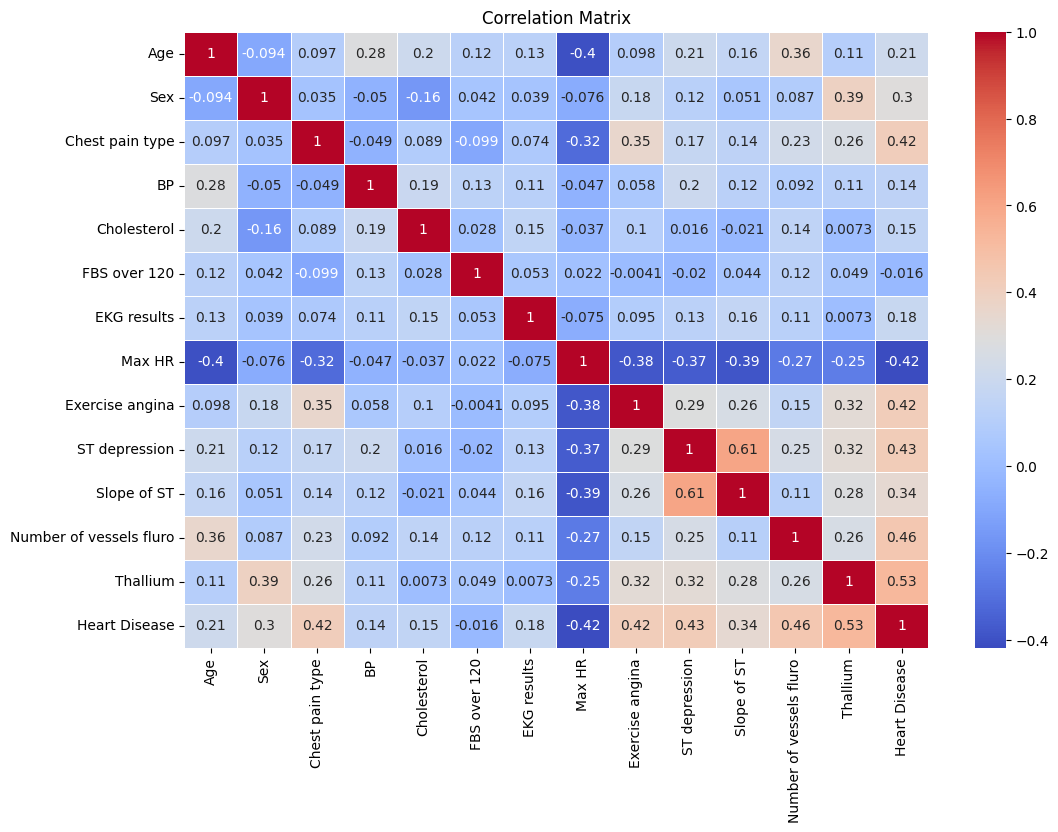

In [11]:
# And now calculate the correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


**FEATURE ENGINEERING**

Feature engineering involves improving the models predictive performance by selecting, creating, modifying, or transforming raw data. In other words, we will apply mathematical reasoning to distribute the data in a fashion that benefits the model. First, we _normalize_ the values. Only the features Age, Blood Pressure, Cholesterol, Maximum Heart Rate, and ST depression were normalized because these are numerical features that have continuous values and varying scales (See histograms for reference). Normalizing them ensures that all numerical inputs have comparable ranges.

In [12]:
from sklearn.preprocessing import StandardScaler

# List of numerical columns to normalize
numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display the first few rows to confirm normalization
print("First few rows after normalization:")
df.head()


First few rows after normalization:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.712094,1,4,-0.033593,1.697746,0,2,-1.759208,0,1.342400,2,3,3,1
1,1.382140,0,3,-0.978399,1.800889,0,2,0.446409,0,0.568889,2,0,7,0
2,0.282294,1,2,-0.411515,0.314953,0,0,-0.375291,0,-0.688067,1,0,7,1
3,1.052186,1,4,-0.159567,0.360290,0,0,-1.932198,1,-0.784756,2,1,7,0
4,2.152032,0,2,-0.663464,0.496303,0,2,-1.240239,1,-0.784756,1,1,3,0


**TRAIN-TEST-VALIDATION SPLIT**

This code performs a _train-validation-test_ split in two stages. First, the dataset is split into training (60%) and a temporary set (40%). Then, the temporary set is split equally into validation (20%) and test (20%) sets. This approach ensures that each dataset is distinct, avoiding data leakage and providing independent subsets for training, tuning, and evaluating the model. The method is versatile and suitable for datasets of any size, supporting rigorous model evaluation.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split features from target variable
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

# Training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



**Random Forest:**  
The Random Forest model is an ensemble learning method that uses bagging (bootstrap aggregation) to build multiple decision trees independently and in parallel. Each tree is trained on a different random subset of the data, and their predictions are aggregated, typically using majority voting for classification tasks. This approach reduces variance and makes Random Forest robust to overfitting. In a binary classification task, Random Forest performs well on small to moderately sized datasets, requires minimal preprocessing, and handles noise effectively. However, it can be computationally expensive during inference, as predictions are aggregated from all trees. Random Forest also provides feature importance scores, which make it moderately interpretable, but the exact decision-making process is not always transparent.  

The `.fit(X_train, y_train)` command trains the model, and often the most computationally expensive load within the program. As we have not yet made any adjustments or finetuning to the model, we can refer to it as a **base model**.

In [14]:
#  Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
# Making predictions with the Random Forest model
y_val_pred_rf = rf_model.predict(X_val)

Here we visualize the evaluation metrics directly. In other projects, we've seen "validation loss" and "accuracy" curves to analyze how the model is learning (training history learning curves). Due to the nature of this data, we use data size learning curves, that may not be as prevelant. We can conceptualize this as "What the model knows"(data-size) vs "How the model learns"(training-history). Provided certain real-life scenarios, the accuracy of the model may be cruicial (such as health care or financial industries where penalties for innacuracies are weighted heavily). In other circumstances, "how the model learns" may be a priority, especially in real-time scenarios where the model may interact with users.  

When evaluating these metrics, think about taking a multiple choice test, and how eliminating all wrong answers is not necessarily the same method as accurately selecting the correct answer. Although both methods may result in a solution, the methodology is different, which here, is relevent.

Let's briefly review these metrics:

**Accuracy:**  
Tthe model correctly predicted the class labels for about 70% of the validation samples. This is a decent baseline, but accuracy alone may not fully reflect the model's effectiveness.  

**Confusion Matrix:**  
The confusion matrix shows that the model is more effective at predicting class 0 (no heart disease) than class 1 (heart disease). This is evident from the higher number of true negatives and relatively fewer false positives compared to false negatives.

**Class 0 (No Heart Disease):**  
Precision: 0.68
Of all predictions made for class 0, 68% were correct. This reflects a moderate level of precision.  

**Recall: 0.86**  
The model correctly identified 86% of all actual class 0 samples, indicating strong sensitivity to the negative class.  

**F1-Score: 0.76**  
Balances precision and recall, suggesting overall good performance for class 0.

**Class 1 (Heart Disease):**  
Precision: 0.76
Of all predictions made for class 1, 76% were correct, which is higher than the negative class.  

**Recall: 0.52**  
The model identified only 52% of the actual class 1 samples, indicating weaker sensitivity to the positive class(heart disease) and a higher rate of false negatives.  

**F1-Score: 0.62**  
Reflects moderate performance for class 1 but lower than for class 0.

In [16]:
# Evaluate the Random Forest model on the validation set
print("Random Forest Model Evaluation on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_val_pred_rf))

Random Forest Model Evaluation on Validation Set:
Accuracy: 0.7037037037037037
Confusion Matrix:
 [[25  4]
 [12 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.86      0.76        29
           1       0.76      0.52      0.62        25

    accuracy                           0.70        54
   macro avg       0.72      0.69      0.69        54
weighted avg       0.72      0.70      0.69        54



We now apply hyperparameter tuning, specifying the constraits of the base model to explore if we can achieve improvments. Here instead of modifying hyperparameters mannually, we automate this process by applying a _Grid Search_ which will find the best parameters for us by trainnig each possible combination within the alloted ranges. The `.fit` function is called here to train through multiple cycles, expect an increase in load.



In [17]:

# Defining parameter grid for Random Forest with more options
param_grid_rf = {
    'n_estimators': [100, 200, 300 ],
    'max_depth': [None, 10, 20, 30 ],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [18]:
# Best parameters and estimator
best_params_rf = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best Parameters Found by Grid Search:")
print(best_params_rf)

Best Parameters Found by Grid Search:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


After locating the best parameters we use those same parameters to train a model.

In [19]:
# Train the model with the best params
best_model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_model_rf.fit(X_train, y_train)

# Predict on validation set using the best model
rf_val_preds = best_rf_model.predict(X_val)


In [20]:
print("Validation Results with Optimized Random Forest:")
print("Accuracy:", accuracy_score(y_val, rf_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, rf_val_preds))
print("Classification Report:\n", classification_report(y_val, rf_val_preds))

Validation Results with Optimized Random Forest:
Accuracy: 0.6851851851851852
Confusion Matrix:
 [[24  5]
 [12 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74        29
           1       0.72      0.52      0.60        25

    accuracy                           0.69        54
   macro avg       0.69      0.67      0.67        54
weighted avg       0.69      0.69      0.68        54



The decision tree from the random forest gives us insight into how it classifies its decisions. Visualizing the output provides more transparency.

In [21]:
# Access a single tree from the trained Random Forest
single_tree = best_rf_model.estimators_[6]  # Select the first tree


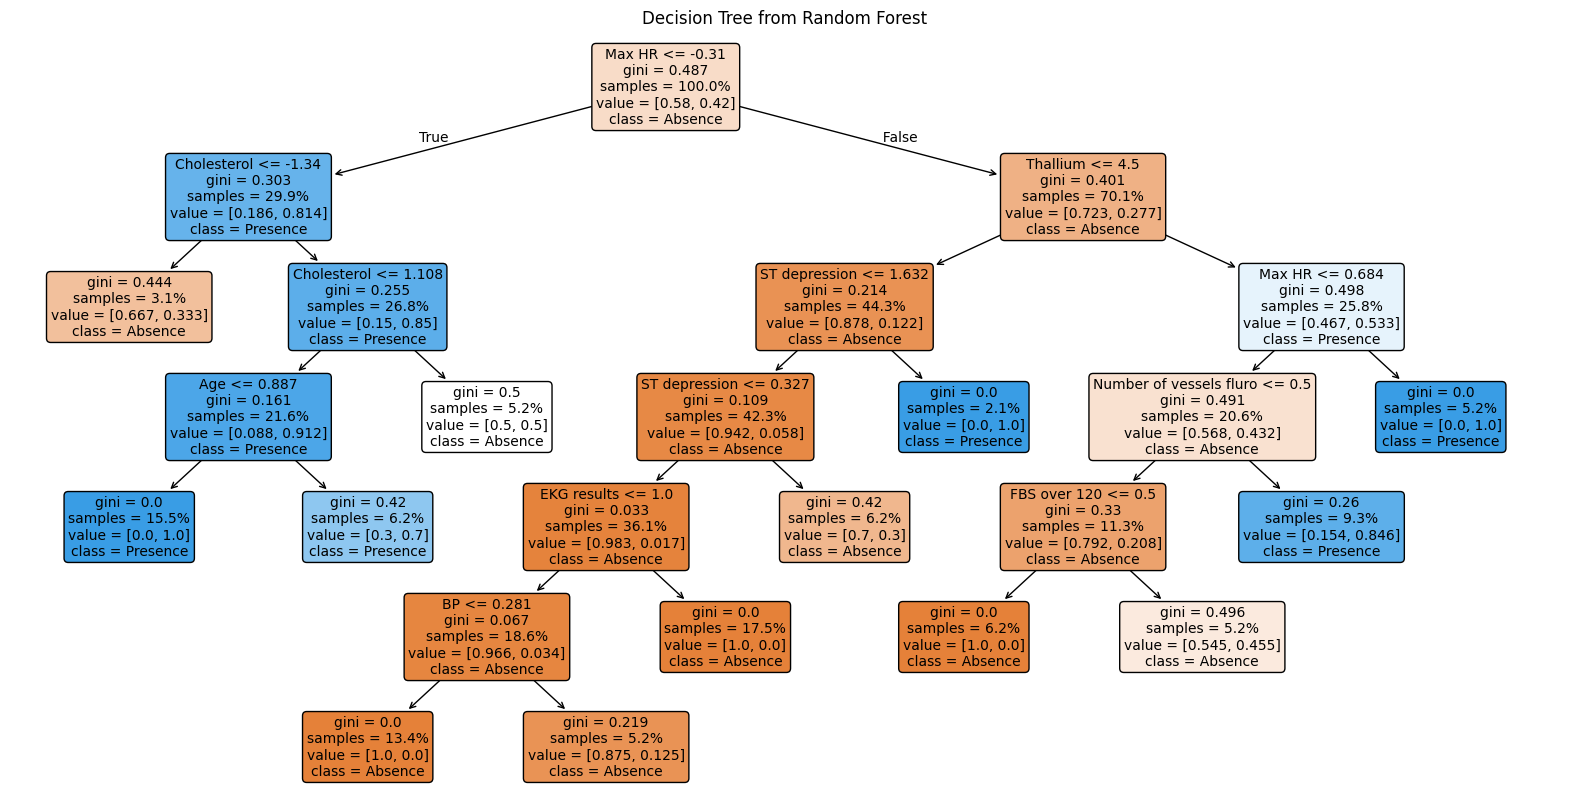

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the selected tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=X.columns,  # Column names for better interpretability
    class_names=['Absence', 'Presence'],  # Target class names
    filled=True,  # Color nodes based on class
    rounded=True,  # Rounded nodes for aesthetics
    proportion=True,  # Scale nodes proportionally to samples
    fontsize=10  # Adjust font size for readability
)
plt.title("Decision Tree from Random Forest")
plt.show()


___
**XGBoost Model**

Extreme Gradient Boosting is a method where decision trees are built sequentially, with each tree correcting the errors of the previous ones by optimizing a loss function. This makes XGBoost particularly effective at capturing complex patterns in the data. In a binary classification task, XGBoost excels at delivering high accuracy on large and complex datasets, often outperforming other models with proper hyperparameter tuning. Compared to Random Forest, XGBoost is computationally more intensive to train due to its sequential learning, but it often requires fewer trees for inference, resulting in faster predictions. While XGBoost is less interpretable due to its advanced optimizations and sequential process, it is a powerful tool for scenarios requiring high precision such as within the healthcare sector.

In [23]:
# Initialize the base XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the training set
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

XGBoost provides marginally better overall performance than Random Forest, with a higher accuracy, improved precision for the positive class, and better recall for the negative class. These results make XGBoost a better choice, particularly if minimizing false positives or achieving more balanced performance is a priority. However, both models share the limitation of weak recall for the positive class, suggesting the need for further adjustments,

In [24]:
# Predict on the validation set
xgb_val_preds = xgb_model.predict(X_val)

# Evaluate the base model
print("Base XGBoost Validation Results:")
print("Accuracy:", accuracy_score(y_val, xgb_val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, xgb_val_preds))
print("Classification Report:\n", classification_report(y_val, xgb_val_preds))

Base XGBoost Validation Results:
Accuracy: 0.7222222222222222
Confusion Matrix:
 [[26  3]
 [12 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.90      0.78        29
           1       0.81      0.52      0.63        25

    accuracy                           0.72        54
   macro avg       0.75      0.71      0.71        54
weighted avg       0.74      0.72      0.71        54



Here, we automate hyperparameter tuning once again. However, instead of performing a GridSearch, which trains on every possible combination of parameters, we use a RandomizedSearch. RandomizedSearch trains on a limited number of randomly selected parameter combinations, retaining the best outcome.

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution (same as before)
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
)

# Perform RandomizedSearchCV with a fixed number of iterations (e.g., 50)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,  # Randomized sampling from the specified distributions
    n_iter=50,  # Number of iterations for random search
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [26]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:36:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [27]:
# Best parameters and estimator from random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# Print the best parameters found by RandomizedSearchCV
print("Best Parameters Found by RandomizedSearchCV:")
print(best_params)


Best Parameters Found by RandomizedSearchCV:
{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}


Using the best parameters recognized by the RandomizedSearch, we train an XGB model. The model shows improvements in accuracy, precision, and recall for class 0 but continues to struggle with recall for class 1. This model might be acceptable if minimizing false positives is critical. However, for this specific case scenario we are prioritizing correct identification of the positive class (We want to correctly diagnose as many people with heart disease as possible) therefore further refinement is necessary.

In [28]:
# Train the XGBoost model with the best parameters
best_xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_xgb = best_xgb_model.predict(X_val)

# Evaluate the predictions
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy on Validation Set: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:36:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on Validation Set: 0.7407

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.97      0.80        29
           1       0.92      0.48      0.63        25

    accuracy                           0.74        54
   macro avg       0.80      0.72      0.72        54
weighted avg       0.79      0.74      0.72        54


Confusion Matrix:
[[28  1]
 [13 12]]


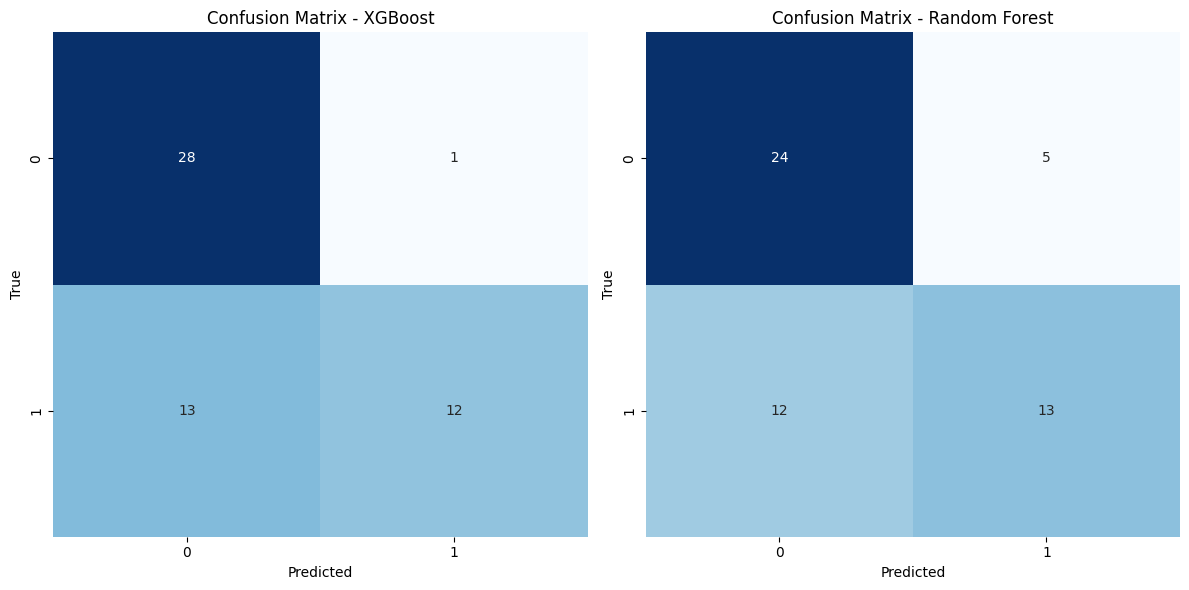

In [29]:
# Make predictions for both models

# Generate confusion matrices for both models
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
cm_rf = confusion_matrix(y_val, rf_val_preds)

# Create a 1x2 subplot to display both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the XGBoost confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix - XGBoost')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot the Random Forest confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix - Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Display the plot
plt.tight_layout()
plt.show()

Reading the confusion matrix:  
_NO Heart Disease: 0_  
_Heart Disease: 1_  

The XGBoost model performs slightly better than the RF model, but both model behave similarly in inaccurately predicting the positive class. We see that the majority of instances that were predicted _class 0_, were actually _class 0_, however we do see inaccuracies where the models predicted _class 0_, the true instance was _class 1_. An imrpoved confusion matrix would present a strong diagnal layout, meaning we would want the bottom left square to appear much lighter and the bottom right square to be much darker



In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Calculate the metrics for both models
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
accuracy_rf = accuracy_score(y_val, rf_val_preds)

precision_xgb = precision_score(y_val, y_pred_xgb)
precision_rf = precision_score(y_val, rf_val_preds)

recall_xgb = recall_score(y_val, y_pred_xgb)
recall_rf = recall_score(y_val, rf_val_preds)

f1_xgb = f1_score(y_val, y_pred_xgb)
f1_rf = f1_score(y_val, rf_val_preds)

auc_xgb = roc_auc_score(y_val, best_xgb_model.predict_proba(X_val)[:, 1])
auc_rf = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])

log_loss_xgb = log_loss(y_val, best_xgb_model.predict_proba(X_val))
log_loss_rf = log_loss(y_val, best_rf_model.predict_proba(X_val))

# Print the results
print("XGBoost Model Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"AUC: {auc_xgb:.4f}")
print(f"Log Loss: {log_loss_xgb:.4f}")

print("\nRandom Forest Model Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")
print(f"Log Loss: {log_loss_rf:.4f}")


XGBoost Model Metrics:
Accuracy: 0.7407
Precision: 0.9231
Recall: 0.4800
F1-Score: 0.6316
AUC: 0.7600
Log Loss: 0.5714

Random Forest Model Metrics:
Accuracy: 0.6852
Precision: 0.7222
Recall: 0.5200
F1-Score: 0.6047
AUC: 0.7586
Log Loss: 0.5945


**Conclusion**  
Both models show functionality as their predictions are moderately accurate, XGBoost moreso than the Random Forest Model. Hyperparameter tuning slightly improved model performance for both models although they both continued to struggle with the recall for the positive class. This could potentially result in a high false-negative rate, which is critical for the healthcare sector. This is likely due to class imbalance (More cases with heart disease than without). Further research would suggest that this can be address with over/undersampling techniques, including using **SMOTE**.

As detailed in the last cell below, we see instances where a more simple, less complex model can improve accuracy at the cost of recall and additional metrics. It is important to keep in mind that the relavance of the accuracy rate is subject to the nature of the task. The objective is to locate the best performing model specific to our task.

Future improvements would include adjusting weights, or decision thresholds in hopes to balance the trade-off between percision and recall. Also exploring feature importance to identify possible refinments for preprocessing.



In [45]:
rf2 = RandomForestClassifier(n_estimators=50, random_state=2)

rf2.fit(X_train, y_train)

y_pred2 = rf2.predict(X_test)

print(f"Accuracy:{accuracy_score(y_test, y_pred2)}")
print(f"Percision: {precision_score(y_val, y_pred2)}")
print(f"Recall: {recall_score(y_val, y_pred2)}")
print(f"F1 Score: {f1_score(y_val, y_pred2)}")


Accuracy:0.7777777777777778
Percision: 0.5625
Recall: 0.36
F1 Score: 0.43902439024390244


In [53]:
#sudo install install pandoc
#pip install pypandoc

In [52]:
#apt-get update
#apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [56]:
import pypandoc

!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Long_AI_Fundamentals.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Long_AI_Fundamentals.ipynb to pdf
[NbConvertApp] Support files will be in Long_AI_Fundamentals_files/
[NbConvertApp] Making directory ./Long_AI_Fundamentals_files
[NbConvertApp] Writing 102828 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 688805 bytes to /content/drive/MyDrive/Colab Notebooks/Long_AI_Fundamentals.pdf


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
